# CS651 Project - Data Science

Authors: 
- Jacky Chen (j57chen@uwaterloo.ca)
- Eric Wang (e246wang@uwaterloo.ca)

Abstract:
- In this notebook, we performed data science using big data (10GB) and distributed systems (Spark)

## Setup

Spark is not installed in Colab so we have to install it ourself. This will take a minute to finish.

In [ ]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop2.tgz
!tar xf spark-3.3.2-bin-hadoop2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop2"

import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession, Window
from pyspark import SparkContext
# from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer

Mount Google drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

proj_root = 'drive/MyDrive/CS651Proj'

Mounted at /content/drive


In [ ]:
# sc = SparkContext(appName="651ProjCleanData", master="local[*]")
spark = SparkSession.builder.appName("cs651-data-science").getOrCreate()

## Load data from Parquet

In [ ]:
df = spark.read.parquet(f"{proj_root}/data/sample0.1.parquet")
# df = spark.read.parquet(f"{proj_root}/data/sample0.002.parquet")

In [ ]:
n_rows = df.count()
n_cols = len(df.columns)
print(f"dataset shape is {n_rows} by {n_cols}")

In [ ]:
df.show(10)

In [ ]:
# view distinct values in a column
col_name = "franchise_make"
df.select(F.col(col_name)).distinct().sort(F.col(col_name)).show(1000)

In [ ]:
df.printSchema()

root
 |-- back_legroom: double (nullable = true)
 |-- body_type: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_fuel_economy: double (nullable = true)
 |-- daysonmarket: integer (nullable = true)
 |-- dealer_zip: integer (nullable = true)
 |-- engine_cylinders: integer (nullable = true)
 |-- engine_displacement: double (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- exterior_color: string (nullable = true)
 |-- fleet: integer (nullable = true)
 |-- frame_damaged: integer (nullable = true)
 |-- franchise_dealer: integer (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: double (nullable = true)
 |-- fuel_tank_volume: double (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- has_accidents: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- highway_fuel_economy: double (nullable = true)
 |-- horsepower: double (nullable = true)
 |-- interior_color: string (nullable = true)
 |-- isCab:

In [ ]:
df.summary().show()

+-------+------------------+-----------+---------+-----------------+------------------+-----------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+--------------+------------------+------------------+---------+-------------------+-----------------+--------------------+-----------------+-----------------+-------------------+------------------+------------------+------------------+-------------+------------------+--------------------+---------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----------------+-------------------+-----------------+--------------------+-----------------+------------+--------------------+------------------+------------+--------------------+------------------+-----------------+------------------+-----------------+---------+--------+----------+
|summary|      back_legroom|  body_t

## EDA and Visualization 

- the average price in each state
- the most popular model in each state
- the most popular body type in each state

### Setup and Load Geo Data

In [ ]:
!pip install -q geopandas
!pip install -q geoplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 80.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 4.5 MB/s eta 0:00:00


In [ ]:
# Import the geopandas and geoplot libraries
# Ref: https://residentmario.github.io/geoplot/quickstart/quickstart.html
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as matplotlib

In [ ]:
# Load US geo data
us_states_geo = gpd.read_file(f"{proj_root}/data/us_states_geo.json")
us_states_geo = us_states_geo.rename(columns={"id":"state_id"})
us_states_geo.head()

,state_id,name,geometry
0,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
1,AK,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,AZ,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,AR,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,CA,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


In [ ]:
# expand multipolygons to multiple rows of polygons because choropleth doesn't support multipolygons :(
exploded_us_states_geo = us_states_geo.explode(index_parts=True)
# AK has an outlier polygon that makes the map look very small. Drop that polygon :(
exploded_us_states_geo = exploded_us_states_geo.drop((1,38))

In [ ]:
exploded_us_states_geo.head()

state_id     name                                           geometry
0 0       AL  Alabama  POLYGON ((-87.35930 35.00118, -85.60667 34.984...
1 0       AK   Alaska  POLYGON ((-131.60202 55.11798, -131.56916 55.2...
  1       AK   Alaska  POLYGON ((-131.83205 55.42469, -131.64584 55.3...
  2       AK   Alaska  POLYGON ((-132.97673 56.43792, -132.73575 56.4...
  3       AK   Alaska  POLYGON ((-133.59563 56.35029, -133.16295 56.3...

### Visualize Avg Price by States

In [ ]:
# find average price by states
groupby_state_df = df.filter(F.col("state_id").isNotNull())\
  .groupBy("state_id")\
  .agg(F.mean("price").alias("mean_price"), F.mean("mileage").alias("mean_mileage"), F.count("state_id").alias("trans_count"))\
  .toPandas()

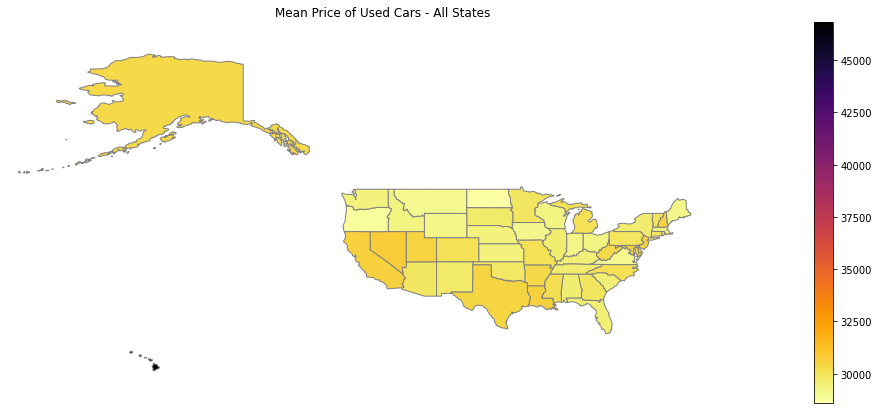

In [ ]:
# join US geo data with our dataframe
plot_df = pd.merge(exploded_us_states_geo, groupby_state_df, how='inner', left_on = 'state_id', right_on = 'state_id')

# plot choropleth graph
gplt.choropleth(plot_df, hue='mean_price'\
                , cmap="inferno_r", edgecolor='grey'\
                , figsize=(20,7), legend=True)
plt.title("Mean Price of Used Cars - All States");

In [ ]:
# inspect mean price dataframe
groupby_state_df[["state_id", "mean_price"]].sort_values(by=['mean_price'], ascending=False).head()

,state_id,mean_price
51,HI,46807.116667
22,DE,30814.685437
12,NV,30781.709934
50,DC,30749.016471
2,LA,30651.417216


Cars are significantly more expensive in Hawaii than other states. So we drop Hawaii and plot again.

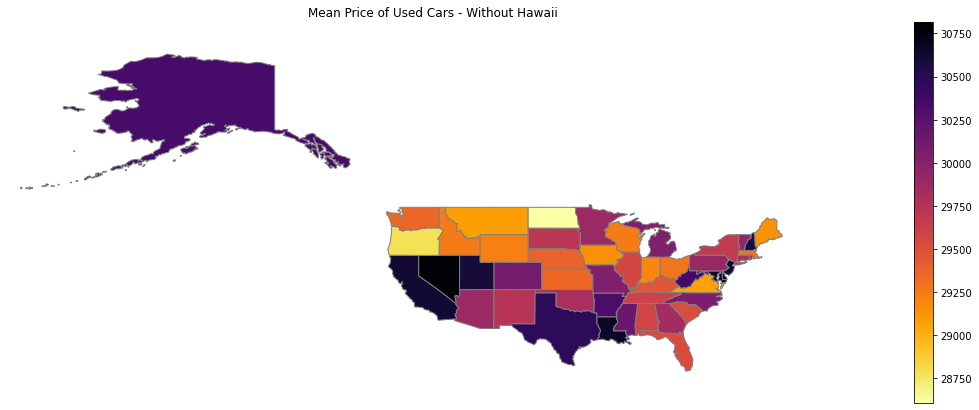

In [ ]:
plot_df_no_HI = plot_df[plot_df["state_id"] != "HI"]
gplt.choropleth(plot_df_no_HI, hue='mean_price'\
                , cmap="inferno_r", edgecolor='grey'\
                , figsize=(20,7), legend=True)
plt.title("Mean Price of Used Cars - Without Hawaii");

### Visualize Avg Mileage by States

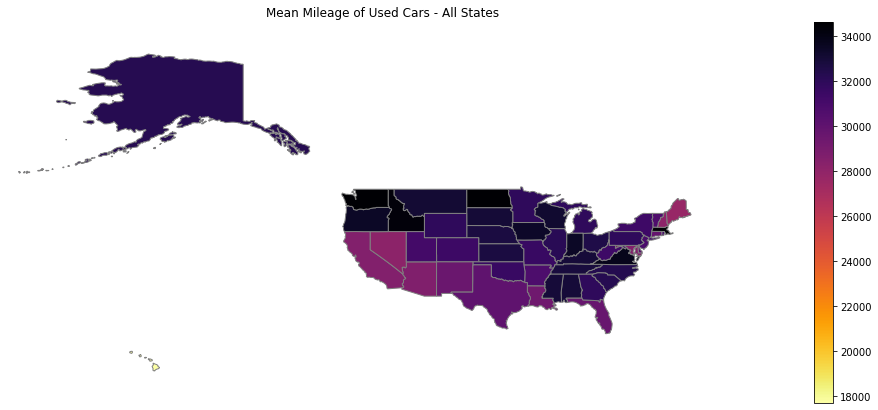

In [ ]:
# plot choropleth graph
gplt.choropleth(plot_df, hue='mean_mileage'\
                , cmap="inferno_r", edgecolor='grey'\
                , figsize=(20,7), legend=True)
plt.title("Mean Mileage of Used Cars - All States");

In [ ]:
# inspect mean mileage dataframe
groupby_state_df[["state_id", "mean_mileage"]].sort_values(by=['mean_mileage'], ascending=True).head()

,state_id,mean_mileage
51,HI,17682.517857
50,DC,23465.542289
48,PR,27635.334318
25,ME,27725.370925
10,NH,28130.041770


Again, Hawaii is an outlier

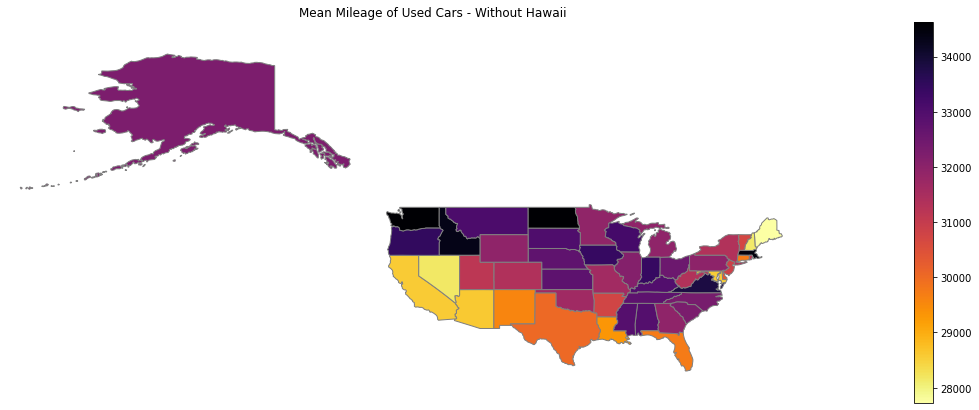

In [ ]:
gplt.choropleth(plot_df_no_HI, hue='mean_mileage'\
                , cmap="inferno_r", edgecolor='grey'\
                , figsize=(20,7), legend=True)
plt.title("Mean Mileage of Used Cars - Without Hawaii");

### Visualize Number of Transactions by States

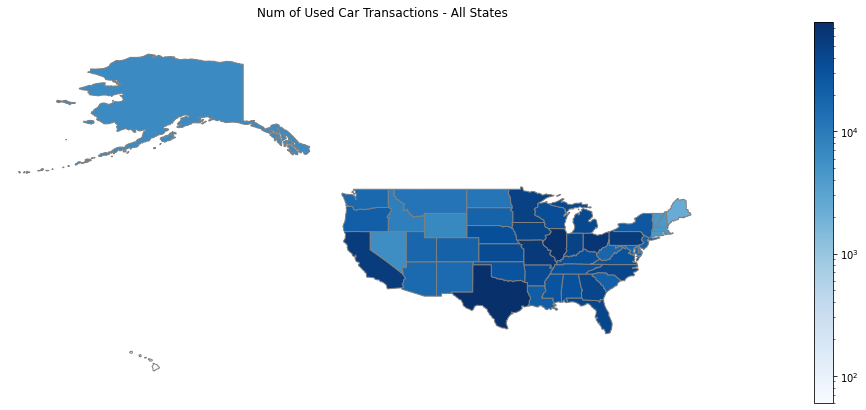

In [ ]:
# plot choropleth graph
gplt.choropleth(plot_df, hue='trans_count'\
                , cmap="Blues", edgecolor='grey'\
                , norm=matplotlib.colors.LogNorm(vmin=plot_df.trans_count.min(), vmax=plot_df.trans_count.max())\
                , figsize=(20,7), legend=True)
plt.title("Num of Used Car Transactions - All States");

### Correlation Matrix

In [ ]:
num_cols = ["price", 
            # "daysonmarket", 
            # "owner_count",
            # "has_accidents", "isCab", "theft_title", "frame_damaged", "is_new", 
            "front_legroom", "back_legroom", "height", "width", "length", "wheelbase",
            "year", "mileage", 
            "engine_cylinders", "fuel_tank_volume", "horsepower",  "power", "torque",

            "savings_amount", "seller_rating",
            "city_fuel_economy", "highway_fuel_economy",
            # "maximum_seating", 
            ]
pd_df = df.select(*num_cols).toPandas().corr()

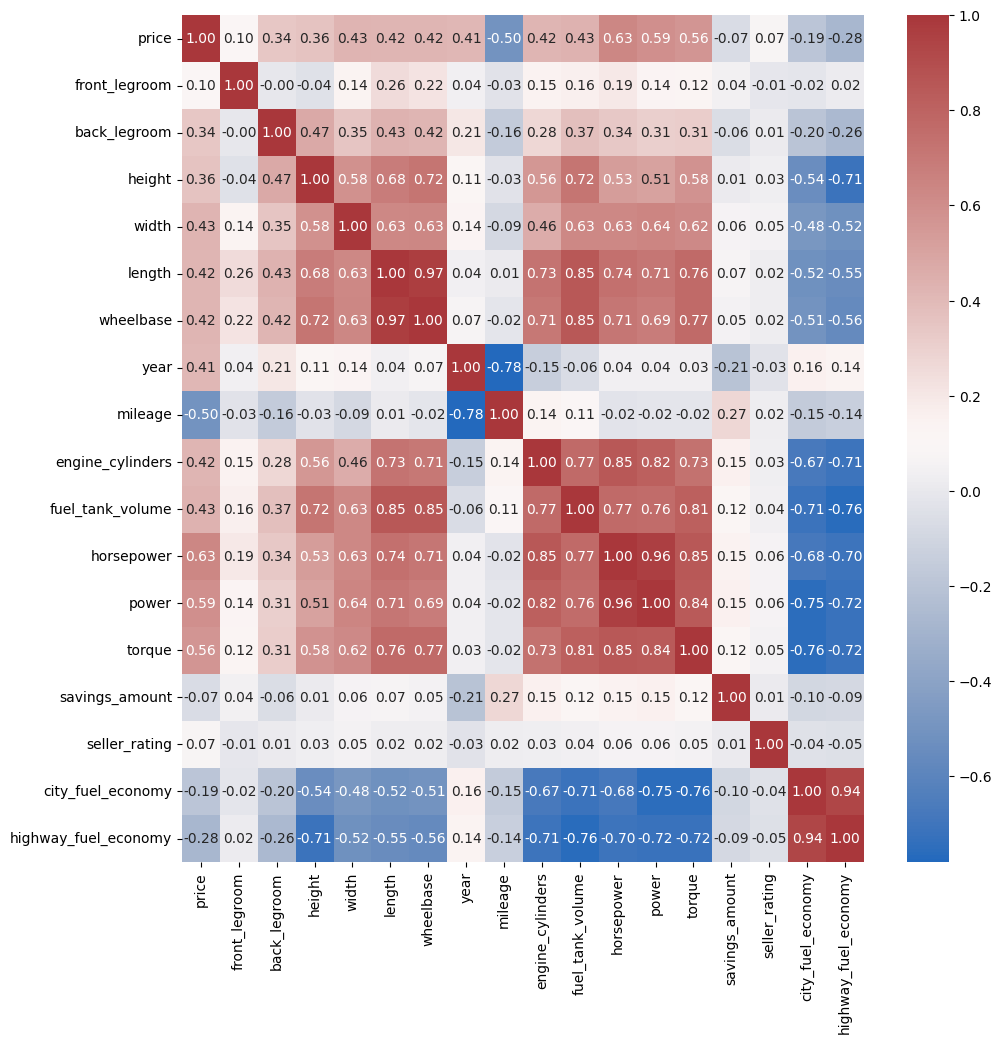

<Figure size 1500x1500 with 0 Axes>

In [ ]:
import seaborn as sn

fig, ax = plt.subplots(figsize=(11,11))
sn.heatmap(pd_df, annot=True, ax=ax, cmap = "vlag", fmt='.2f')
plt.figure(figsize=(15,15))
plt.show()

### Car makes

In [ ]:
make_df = df.groupBy('make_name')\
    .agg(F.count("rowno").alias("count"))\
    .toPandas()\
    .sort_values(by=["count"], ascending=False)
make_df['percent'] = make_df['count']/n_rows * 100
make_df['cum_percent'] = make_df['percent'].cumsum()

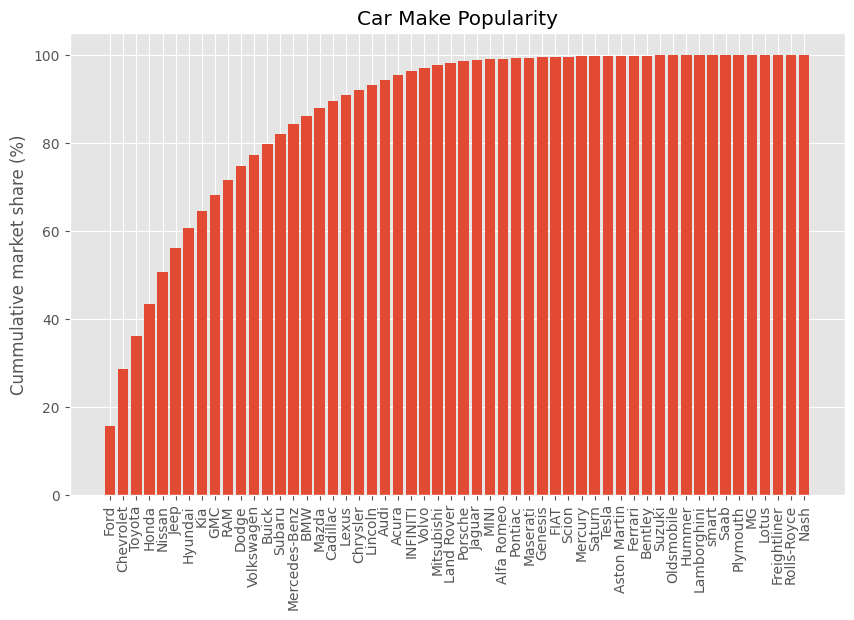

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(10,6))
plt.bar(x = make_df['make_name'], height = make_df['cum_percent'])
plt.xticks(rotation=90)
# plt.title('Car Make Popularity')
plt.ylabel('Cumulative market share (%)')
plt.show()

### Car Model

In [ ]:
model_df = df.groupBy('model_name')\
    .agg(F.count("rowno").alias("count"))\
    .toPandas()\
    .sort_values(by=["count"], ascending=False)
model_df['percent'] = model_df['count']/n_rows * 100
model_df['cum_percent'] = model_df['percent'].cumsum()

In [ ]:
model_df

,model_name,count,percent,cum_percent
81,F-150,1141,4.143967,4.143967
364,Silverado 1500,718,2.607685,6.751653
5,1500,624,2.266289,9.017941
460,Equinox,585,2.124646,11.142587
381,Escape,550,1.997530,13.140118
...,...,...,...,...
241,Yukon Hybrid,1,0.003632,99.985473
45,Solstice,1,0.003632,99.989104
583,Catera,1,0.003632,99.992736
232,Bonneville,1,0.003632,99.996368


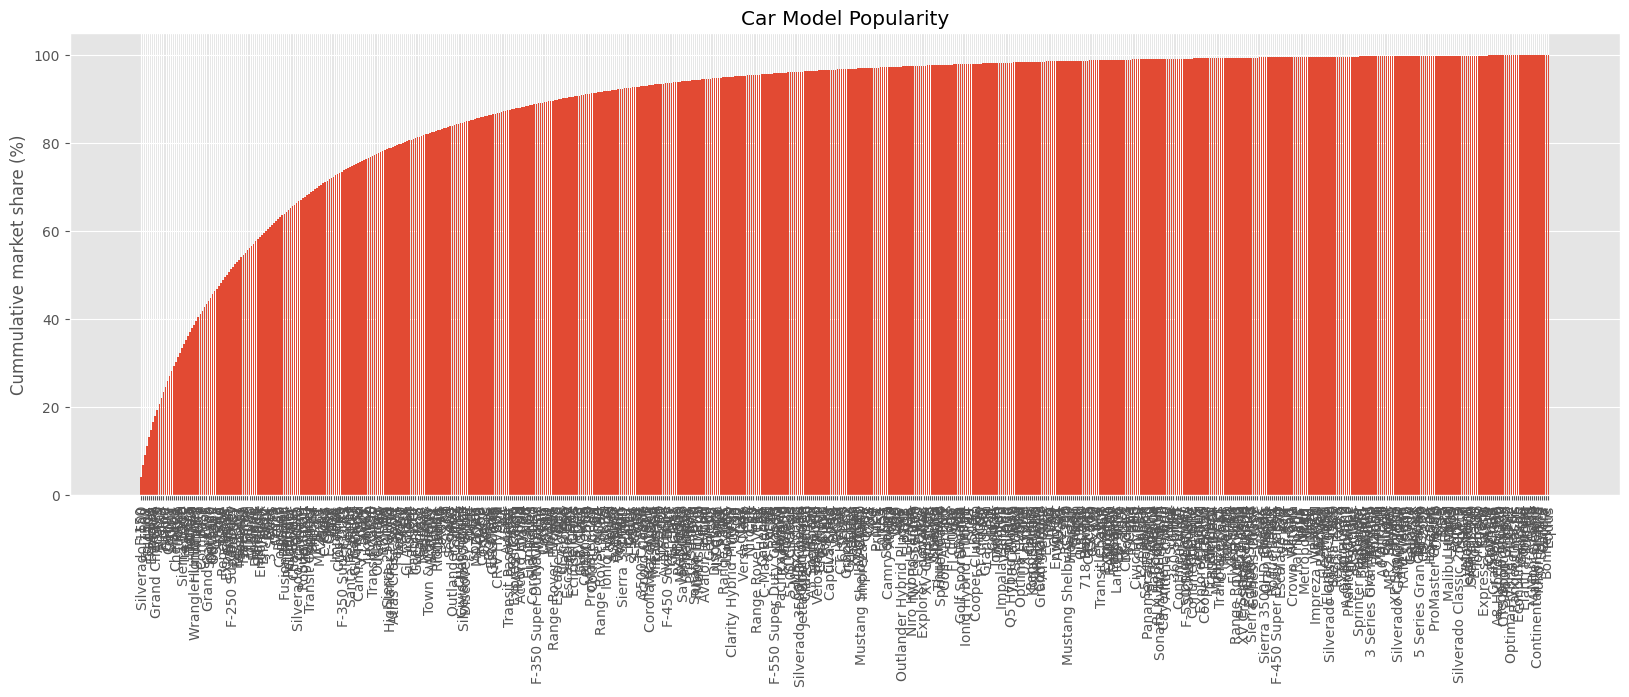

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(20,6))
plt.bar(x = model_df['model_name'], height = model_df['cum_percent'])
plt.xticks(rotation=90)
plt.title('Car Model Popularity')
plt.ylabel('Cummulative market share (%)')
plt.show()

### Body type

In [ ]:
body_type_df = df.filter(F.col("body_type").isNotNull())\
    .groupBy('body_type')\
    .agg(F.count("rowno").alias("count"))\
    .toPandas()\
    .sort_values(by=["count"], ascending=False)
body_type_df['percent'] = body_type_df['count']/n_rows * 100
body_type_df['cum_percent'] = body_type_df['percent'].cumsum()

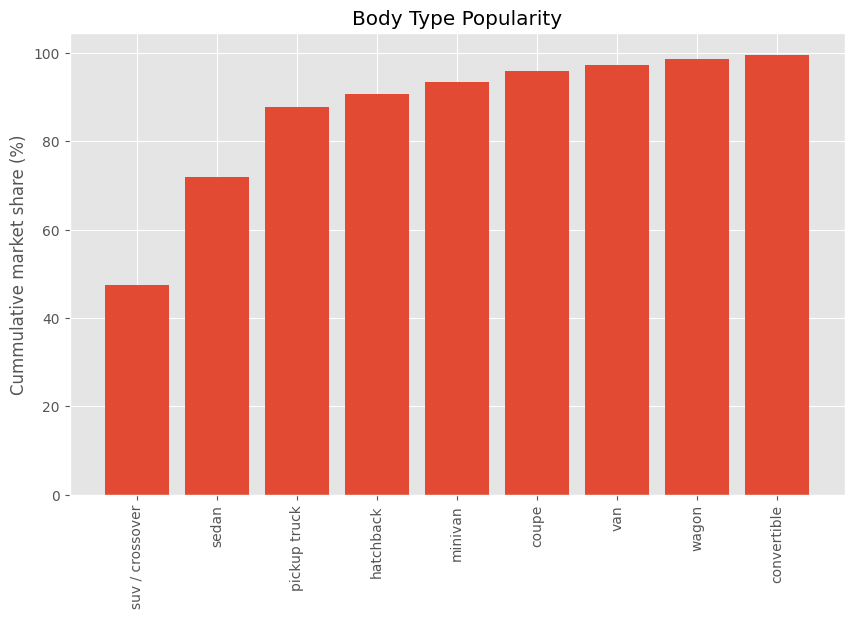

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(10,6))
plt.bar(x = body_type_df['body_type'], height = body_type_df['cum_percent'])
plt.xticks(rotation=90)
plt.title('Body Type Popularity')
plt.ylabel('Cummulative market share (%)')
plt.show()

### Transmission

In [ ]:
transmission_display_df = df.filter(F.col("engine_type").isNotNull())\
    .groupBy('engine_type')\
    .agg(F.count("rowno").alias("count"))\
    .toPandas()\
    .sort_values(by=["count"], ascending=False)
transmission_display_df['percent'] = transmission_display_df['count']/n_rows * 100
transmission_display_df['cum_percent'] = transmission_display_df['percent'].cumsum()

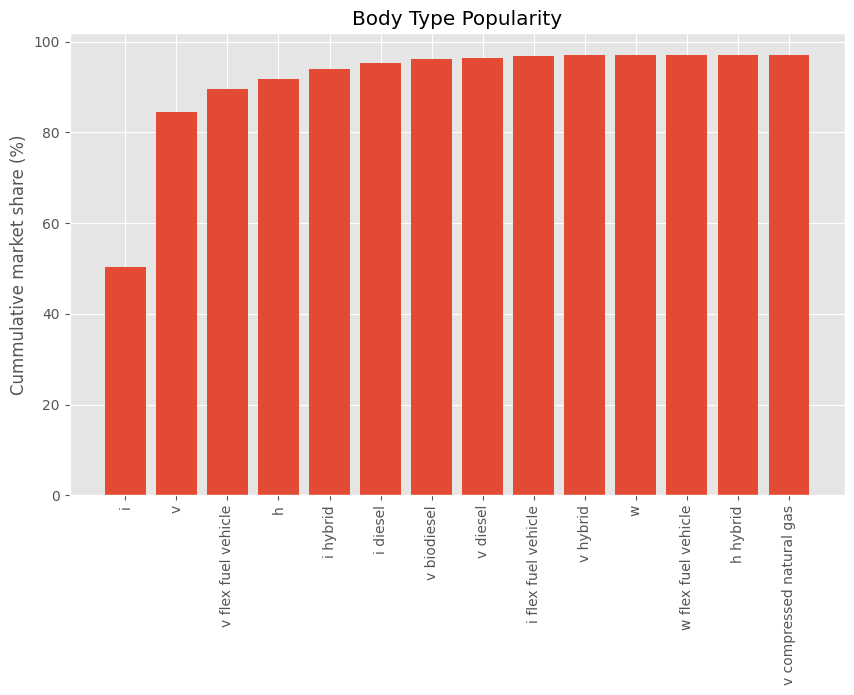

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(10,6))
plt.bar(x = transmission_display_df['engine_type'], height = transmission_display_df['cum_percent'])
plt.xticks(rotation=90)
plt.title('Body Type Popularity')
plt.ylabel('Cummulative market share (%)')
plt.show()

### Color

In [ ]:
listing_color_df = df.filter(F.col("listing_color").isNotNull())\
    .groupBy('listing_color')\
    .agg(F.count("rowno").alias("count"))\
    .toPandas()\
    .sort_values(by=["count"], ascending=False)
listing_color_df['percent'] = listing_color_df['count']/n_rows * 100
listing_color_df['cum_percent'] = listing_color_df['percent'].cumsum()

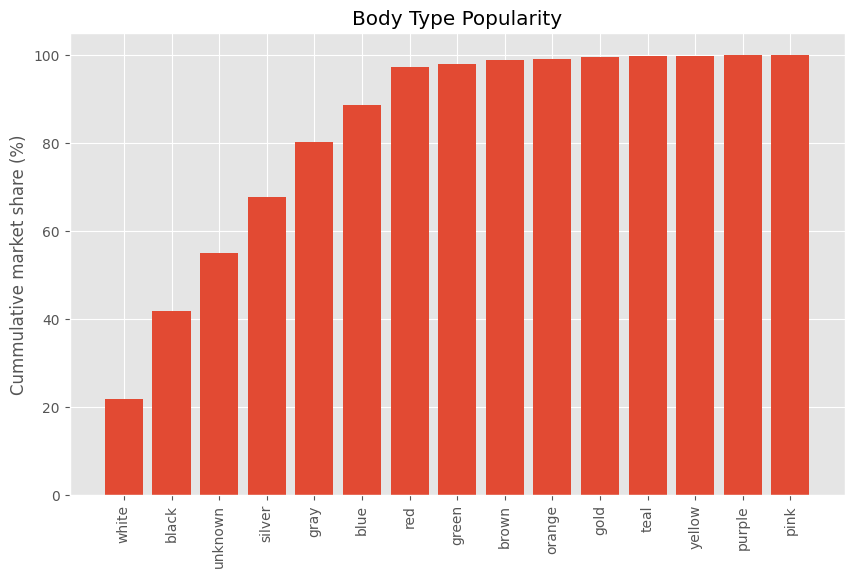

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(10,6))
plt.bar(x = listing_color_df['listing_color'], height = listing_color_df['cum_percent'])
plt.xticks(rotation=90)
plt.title('Body Type Popularity')
plt.ylabel('Cummulative market share (%)')
plt.show()

### Popularity of fuel type

In [ ]:
transmission_df = df.groupBy('fuel_type')\
    .agg(F.count("rowno").alias("count"))\
    .toPandas()\
    .sort_values(by=["count"], ascending=False)
transmission_df['percent'] = transmission_df['count']/n_rows * 100

In [ ]:
transmission_df

,fuel_type,count,percent
1,Gasoline,23912,86.845355
4,Flex Fuel Vehicle,1442,5.237161
2,None,684,2.484201
5,Hybrid,666,2.418828
3,Diesel,437,1.587129
0,Biodiesel,239,0.868018
6,Electric,152,0.552045
7,Compressed Natural Gas,2,0.007264


## Prepare the Data

- Data cleaning
  - Fill in missing values
- Feature engineering
  - Decompose features
- Feature scaling
  - standardize or normalize features

### Data cleaning

#### Categorical features

In [ ]:
categorical_cols = [
    'body_type'
    # ,'franchise_make'
    ,'make_name'
    ,'transmission_display'
    # ,'exterior_color'
    # ,'interior_color'
    ,'listing_color'
    ,'state_id'
    # ,'franchise_make'
]

df = df.fillna(value="N/A",subset=categorical_cols)

#### Numeric features

##### Mileage Fill NA

In [ ]:
# get mean mileage by state
mean_mileage_df = spark.read.parquet(f"{proj_root}/data/mean_mileage_by_state.parquet")

In [ ]:
# if a car is labeled as new, fill mileage with a small numer
filled_df = df.withColumn("mileage", F.when(df.is_new == 1, 5))

In [ ]:
# join by state ID
filled_df = filled_df.join(mean_mileage_df, filled_df.state_id == mean_mileage_df.state_id2, 'left').drop("state_id2")
# create a new mileage column and fill na with state mean mileage
filled_df = filled_df.withColumn('new_mileage',F.when(filled_df.mileage.isNull(), filled_df.mean_mileage).otherwise(filled_df.mileage))

In [ ]:
# drop interim columns
filled_df = filled_df.drop("mean_mileage")\
  .withColumnRenamed("mileage", "old_mileage")\
  .withColumnRenamed("new_mileage", "mileage")

In [ ]:
# check results
filled_df.filter(F.col("old_mileage").isNull()).select(*["state_id","old_mileage","mileage", "is_new"]).show(3)
filled_df.filter(F.col("old_mileage").isNotNull()).select(*["state_id","old_mileage","mileage", "is_new"]).show(3)

+--------+-----------+------------------+------+
|state_id|old_mileage|           mileage|is_new|
+--------+-----------+------------------+------+
|      TX|       null|29892.585938878154|     0|
|      AZ|       null| 28975.27989411671|     0|
|      MO|       null|31779.016154573197|     0|
+--------+-----------+------------------+------+
only showing top 3 rows

+--------+-----------+-------+------+
|state_id|old_mileage|mileage|is_new|
+--------+-----------+-------+------+
|      WV|          5|    5.0|     1|
|      MS|          5|    5.0|     1|
|      KY|          5|    5.0|     1|
+--------+-----------+-------+------+
only showing top 3 rows



##### Horse power Fill NA

In [ ]:
# find mean mileage by state
mean_hp_by_model = spark.read.parquet(f"{proj_root}/data/mean_hp_by_model.parquet")

In [ ]:
mean_hp_by_model.filter(F.col("mean_horsepower").isNull() | F.col("mean_engine_cylinders").isNull() | F.col("mean_fuel_tank_volume").isNull())\
  .select(*["make_name2", "model_name2", 
            "mean_horsepower", "mean_engine_cylinders", "mean_fuel_tank_volume",
            "mean_back_legroom", "mean_height", "mean_width", "mean_length", "mean_city_fuel_economy", "mean_highway_fuel_economy"])\
  .show()

+-----------+--------------------+---------------+---------------------+---------------------+-----------------+-----------+----------+-----------+----------------------+-------------------------+
| make_name2|         model_name2|mean_horsepower|mean_engine_cylinders|mean_fuel_tank_volume|mean_back_legroom|mean_height|mean_width|mean_length|mean_city_fuel_economy|mean_highway_fuel_economy|
+-----------+--------------------+---------------+---------------------+---------------------+-----------------+-----------+----------+-----------+----------------------+-------------------------+
|lamborghini|              espada|           null|                 null|                 null|             null|       null|      null|       null|                  null|                     null|
|        gmc|            s15jimmy|          125.0|                  6.0|                 null|             null|       null|      null|       null|                  null|                     null|
|     datsun|  

In [ ]:
# join by make, model and year
filled_df = filled_df\
  .join(mean_hp_by_model, (filled_df.make_name == mean_hp_by_model.make_name2) & (filled_df.model_name == mean_hp_by_model.model_name2), 'left')\
  .drop(*["model_name2", "make_name2"])
# create a new mileage column and fill na with state mean mileage
filled_df = filled_df.withColumn('new_horsepower', F.when(filled_df.horsepower.isNull(), filled_df.mean_horsepower).otherwise(filled_df.horsepower))\
  .withColumn('new_engine_cylinders', F.when(filled_df.engine_cylinders.isNull(), filled_df.mean_engine_cylinders).otherwise(filled_df.engine_cylinders))\
  .withColumn('new_fuel_tank_volume', F.when(filled_df.fuel_tank_volume.isNull(), filled_df.mean_fuel_tank_volume).otherwise(filled_df.fuel_tank_volume))\
  .withColumn('new_back_legroom', F.when(filled_df.back_legroom.isNull(), filled_df.mean_back_legroom).otherwise(filled_df.back_legroom))\
  .withColumn('new_height', F.when(filled_df.height.isNull(), filled_df.mean_height).otherwise(filled_df.height))\
  .withColumn('new_width', F.when(filled_df.width.isNull(), filled_df.mean_width).otherwise(filled_df.width))\
  .withColumn('new_length', F.when(filled_df.length.isNull(), filled_df.mean_length).otherwise(filled_df.length))\
  .withColumn('new_city_fuel_economy', F.when(filled_df.city_fuel_economy.isNull(), filled_df.mean_city_fuel_economy).otherwise(filled_df.city_fuel_economy))\
  .withColumn('new_highway_fuel_economy', F.when(filled_df.highway_fuel_economy.isNull(), filled_df.mean_highway_fuel_economy).otherwise(filled_df.highway_fuel_economy))

In [ ]:
# check results
filled_df.select(*["year", "model_name", "make_name",
                   "horsepower","new_horsepower", 
                   "engine_cylinders","new_engine_cylinders", 
                   "fuel_tank_volume","new_fuel_tank_volume", 
                   ]).show()

+----+--------------+-------------+----------+------------------+----------------+--------------------+----------------+--------------------+
|year|    model_name|    make_name|horsepower|    new_horsepower|engine_cylinders|new_engine_cylinders|fuel_tank_volume|new_fuel_tank_volume|
+----+--------------+-------------+----------+------------------+----------------+--------------------+----------------+--------------------+
|2021|          cx30|        mazda|      null|             186.0|            null|                 4.0|            null|  12.999871818347476|
|2021|            k5|          kia|      null|             180.0|               4|                 4.0|            null|  15.800000000001633|
|2021|eserieschassis|         ford|      null|300.99029126213594|               8|                 8.0|            null|                40.0|
|2021|        ascent|       subaru|      null|             260.0|               4|                 4.0|            null|   19.30000000000165|
|2021|

In [ ]:
# drop interim columns
filled_df = filled_df\
  .drop("horsepower")\
  .withColumnRenamed("new_horsepower", "horsepower")\
  .drop("engine_cylinders")\
  .withColumnRenamed("new_engine_cylinders", "engine_cylinders")\
  .drop("fuel_tank_volume")\
  .withColumnRenamed("new_fuel_tank_volume", "fuel_tank_volume")\
  .drop("back_legroom")\
  .withColumnRenamed("new_back_legroom", "back_legroom")\
  .drop("height")\
  .withColumnRenamed("new_height", "height")\
  .drop("width")\
  .withColumnRenamed("new_width", "width")\
  .drop("length")\
  .withColumnRenamed("new_length", "length")\
  .drop("city_fuel_economy")\
  .withColumnRenamed("new_city_fuel_economy", "city_fuel_economy")\
  .drop("highway_fuel_economy")\
  .withColumnRenamed("new_highway_fuel_economy", "highway_fuel_economy")

### Feature selection

In [ ]:
# from pyspark.ml.feature import PCA
# pca = PCA().setInputCol("features").setK(2)
# pca.fit(scaleDF).transform(scaleDF).show(20, False)

### Feature engineering

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Normalizer

In [ ]:
numeric_cols = [x + '_numeric' for x in categorical_cols]
onehot_cols = [x + '_onehot' for x in categorical_cols]
# apply StringIndexer to convert the features into the numerical format
str_indexer = StringIndexer(inputCols=categorical_cols, outputCols=numeric_cols)
# apply OneHotEncoder
one_hot_encoder = OneHotEncoder(inputCols=numeric_cols,outputCols=onehot_cols)#.fit(indexed_df)

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
# create pipeline
pipeline = Pipeline(stages=[str_indexer,
                            one_hot_encoder])
# transform dataset
df_transformed = pipeline.fit(filled_df).transform(filled_df)

In [ ]:
# take a look
df_transformed.select(*onehot_cols).show()

+----------------+----------------+---------------------------+--------------------+---------------+
|body_type_onehot|make_name_onehot|transmission_display_onehot|listing_color_onehot|state_id_onehot|
+----------------+----------------+---------------------------+--------------------+---------------+
|       (9,[],[])| (54,[16],[1.0])|             (34,[0],[1.0])|      (14,[1],[1.0])|(52,[35],[1.0])|
|       (9,[],[])|  (54,[7],[1.0])|             (34,[0],[1.0])|      (14,[3],[1.0])|(52,[21],[1.0])|
|       (9,[],[])|  (54,[0],[1.0])|             (34,[5],[1.0])|      (14,[0],[1.0])|(52,[16],[1.0])|
|       (9,[],[])| (54,[13],[1.0])|             (34,[1],[1.0])|      (14,[4],[1.0])|(52,[37],[1.0])|
|       (9,[],[])|  (54,[7],[1.0])|             (34,[0],[1.0])|      (14,[0],[1.0])|(52,[21],[1.0])|
|       (9,[],[])|  (54,[6],[1.0])|            (34,[16],[1.0])|      (14,[3],[1.0])|(52,[14],[1.0])|
|       (9,[],[])|  (54,[6],[1.0])|             (34,[3],[1.0])|      (14,[2],[1.0])|(52,[29

In [ ]:
# take a look
cat_col = "make_name"
num_col = cat_col + '_numeric'
onehot_col = cat_col + '_onehot'
df_transformed.select(F.col(cat_col),F.col(num_col),F.col(onehot_col)).show()

+-------------+-----------------+----------------+
|    make_name|make_name_numeric|make_name_onehot|
+-------------+-----------------+----------------+
|        mazda|             16.0| (54,[16],[1.0])|
|          kia|              7.0|  (54,[7],[1.0])|
|         ford|              0.0|  (54,[0],[1.0])|
|       subaru|             13.0| (54,[13],[1.0])|
|          kia|              7.0|  (54,[7],[1.0])|
|      hyundai|              6.0|  (54,[6],[1.0])|
|      hyundai|              6.0|  (54,[6],[1.0])|
|          kia|              7.0|  (54,[7],[1.0])|
|          kia|              7.0|  (54,[7],[1.0])|
|         ford|              0.0|  (54,[0],[1.0])|
|   alfa romeo|             31.0| (54,[31],[1.0])|
|mercedes-benz|             14.0| (54,[14],[1.0])|
|      porsche|             27.0| (54,[27],[1.0])|
|        mazda|             16.0| (54,[16],[1.0])|
|mercedes-benz|             14.0| (54,[14],[1.0])|
|mercedes-benz|             14.0| (54,[14],[1.0])|
|    chevrolet|              1.

In [ ]:
# # combine categorical features with numerica features
model_cols = onehot_cols + ['year', 'mileage', 
                            'horsepower', 'engine_cylinders', 'fuel_tank_volume',
                            "back_legroom", "height", "width", "length", 
                            # "city_fuel_economy", "highway_fuel_economy"
                            ]

In [ ]:
df_transformed = df_transformed.filter(F.col("horsepower").isNotNull() & F.col("engine_cylinders").isNotNull() & F.col("fuel_tank_volume").isNotNull()\
                                       & F.col("back_legroom").isNotNull() & F.col("height").isNotNull() & F.col("width").isNotNull() & F.col("length").isNotNull()\
                                       & F.col("city_fuel_economy").isNotNull() & F.col("highway_fuel_economy").isNotNull()
                                       )

In [ ]:
df_transformed.select(*model_cols).show()

+----------------+----------------+---------------------------+--------------------+---------------+----+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|body_type_onehot|make_name_onehot|transmission_display_onehot|listing_color_onehot|state_id_onehot|year|           mileage|        horsepower| engine_cylinders|  fuel_tank_volume|      back_legroom|            height|            width|            length|
+----------------+----------------+---------------------------+--------------------+---------------+----+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|       (9,[],[])| (54,[16],[1.0])|             (34,[0],[1.0])|      (14,[1],[1.0])|(52,[35],[1.0])|2021|               5.0|             186.0|              4.0|12.999871818347476| 36.29999999999741| 62.00594213514643|  70.700000000

In [ ]:
# vectorize features
vectorAssembler = VectorAssembler(inputCols = model_cols, outputCol = 'features')
vectorized_df = vectorAssembler.transform(df_transformed)
vectorized_df = vectorized_df.select(['features', 'price'])
vectorized_df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|features                                                                                                                                                                                                                               |price   |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|(172,[25,63,98,146,163,164,165,166,167,168,169,170,171],[1.0,1.0,1.0,1.0,2021.0,5.0,186.0,4.0,12.999871818347476,36.29999999999741,62.00594213514643,70.700000000007,173.0])                                                           |28745.0 |
|(172,[16,63,100,132,163,164

### Feature scaling

In [ ]:
from pyspark.ml.feature import StandardScaler
# scale vectors
scaler = StandardScaler(withStd=True, withMean=False).setInputCol("features").setOutputCol("scaledFeatures")
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(vectorized_df)
# Normalize each feature to have unit standard deviation.
scaled_df = scalerModel.transform(vectorized_df)

scaled_df.show(3, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                    |price  |scaledFeatures                                                                                                                                                                                                                                                                                             |
+-

In [ ]:
# drop interim columns
scaled_df = scaled_df\
  .drop("features")\
  .withColumnRenamed("scaledFeatures", "features")

### Save to disk

In [ ]:
xy_df = scaled_df\
  .select(F.col("features"), F.col("price"))\
  .withColumnRenamed("price", "label")


# xy_df = vectorized_df.select(F.col("features"), F.col("price"))\
#   .withColumnRenamed("price", "label")

In [ ]:
xy_df.show(3, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|features                                                                                                                                                                                                                                                                                                   |label  |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|(172,[25,63,98,146,163,164,165,166,167,168,169,170,171],[7.5937634154

In [ ]:
# xy_df.write.mode('overwrite').parquet(f"{proj_root}/data/x_y_df.parquet")

In [ ]:
xy_df = spark.read.parquet(f"{proj_root}/data/x_y_df.parquet")

### Train test split

In [ ]:
# train test split
splits = xy_df.randomSplit([0.8, 0.2], 651)
train_df = splits[0]
test_df = splits[1]

In [ ]:
train_df.show(3, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|features                                                                                                                                                      |label  |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|(174,[0,9,63,97,111,163,164,165,166,167,168,169,170,171,172,173],[1.0,1.0,1.0,1.0,1.0,2014.0,32336.23484443675,240.0,4.0,15.1,36.8,66.3,81.8,178.1,23.0,32.0])|14979.0|
|(174,[0,9,63,97,111,163,164,165,166,167,168,169,170,171,172,173],[1.0,1.0,1.0,1.0,1.0,2018.0,32336.23484443675,245.0,4.0,15.7,37.3,66.3,81.8,178.1,22.0,28.0])|15995.0|
|(174,[0,9,63,97,111,163,164,165,166,167,168,169,170,171,172,173],[1.0,1.0,1.0,1.0,1.0,2018.0,32336.23484443675,287.0,6.0,18.6,44.3,68.0,88.8,201.8,16.0,23

## Regression Models to Predict Price

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

### Linear Regression

In [ ]:
# lr = LinearRegression(featuresCol = 'normFeatures', labelCol='price'
#                       , maxIter=100, regParam=0.0, elasticNetParam=0.0
#                       , solver="auto")
lr = LinearRegression(featuresCol = 'features', labelCol='label'
                      , maxIter=50, regParam=0.1, elasticNetParam=0.0
                      , solver="auto")
lr_model = lr.fit(train_df)

In [ ]:
summary = lr_model.summary

In [ ]:
# summary.residuals.show()
print(summary.totalIterations)
print(summary.r2)
print(summary.rootMeanSquaredError)
print(summary.meanAbsoluteError)
print(summary.explainedVariance)
# print(summary.pValues)
# print(summary.residuals)

0
0.7625253308794757
7956.400600061164
5110.572128533675
203135197.76510373


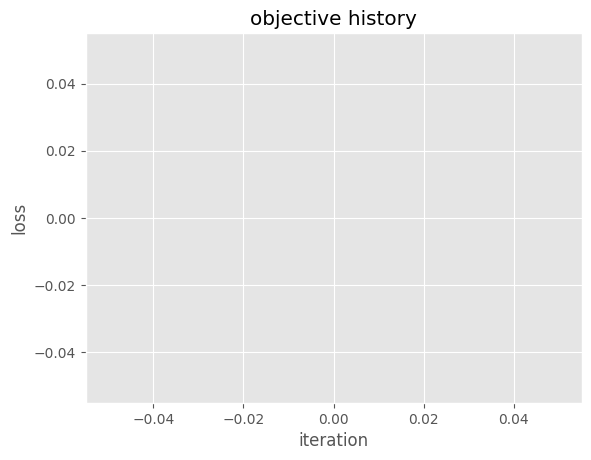

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.plot(summary.objectiveHistory)
plt.title('objective history')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

In [ ]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [921.0973137528409,-1452.61717287717,-468.57278913546594,787.7730216358339,-3421.1096000435687,-670.9955897837258,-397.5415009578157,2343.9505694031454,4907.173372317139,-91993.06243636867,-91565.07610525574,-87072.47967848011,-88522.03263564457,-91125.17949079475,-89497.59037291903,-90130.47145127559,-92064.24226138077,-89877.94089760174,-91761.48794111772,-96893.9684260323,-88482.00089750226,-88759.0822936887,-87217.00777134996,-73529.69451340716,-80121.5429495228,-88248.00045546306,-83489.7166642215,-81954.6129816122,-77176.77340265497,-83548.03691898308,-91909.7113585419,-85996.86875420716,-88001.47395997832,-82833.37594235768,-88842.12047797444,-74323.72929376388,-54137.390684535836,-79992.14201631708,-84696.07589310483,-83661.5521205471,-85368.41387936955,-85211.00788668099,-72625.83531166094,-85653.98759740098,-89084.06877252187,-85761.52645188388,-82980.70660174628,0.0,-8259.18451778485,32531.053325691624,35677.71672480725,-87927.79048117023,-78863.22202589652,-89

In [ ]:
# Make predictions.
lr_model.setFeaturesCol("features")
lr_model.setPredictionCol("prediction")
predictions = lr_model.transform(test_df)

In [ ]:
predictions.show(truncate=False)

+---------------------------------------------------------------------------------------+-------+------------------+
|features                                                                               |label  |prediction        |
+---------------------------------------------------------------------------------------+-------+------------------+
|(166,[0,9,63,97,111,163,164,165],[1.0,1.0,1.0,1.0,1.0,2017.0,365.0,32635.315086782375])|31813.0|35394.92201412702 |
|(166,[0,9,63,97,111,163,164,165],[1.0,1.0,1.0,1.0,1.0,2020.0,180.0,5.0])               |22135.0|27017.87468185369 |
|(166,[0,9,63,97,111,163,164,165],[1.0,1.0,1.0,1.0,1.0,2020.0,365.0,5.0])               |59680.0|48176.36923405249 |
|(166,[0,9,63,97,111,163,164,165],[1.0,1.0,1.0,1.0,1.0,2020.0,375.0,5.0])               |62347.0|49320.071642279625|
|(166,[0,9,63,97,112,163,164,165],[1.0,1.0,1.0,1.0,1.0,2017.0,245.0,28420.878131347326])|17998.0|22448.456112985965|
|(166,[0,9,63,97,112,163,164,165],[1.0,1.0,1.0,1.0,1.0,2020.0,30

### GLM

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
glr = GeneralizedLinearRegression()\
  .setFamily("gaussian")\
  .setLink("identity")

cv_pipeline = Pipeline().setStages([glr])
# 
params = ParamGridBuilder()\
  .addGrid(glr.regParam, [0, 0.2, 0.4, 0.6, 0.8])\
  .build()

evaluator = RegressionEvaluator()\
  .setMetricName("r2")\
  .setPredictionCol("prediction")\
  .setLabelCol("label")

cv = CrossValidator()\
  .setEstimator(cv_pipeline)\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(params)\
  .setNumFolds(5) # should always be 3 or more
  
cv_model = cv.fit(train_df)

In [ ]:
for (i, r2) in enumerate(cv_model.avgMetrics):
  print(f"R2 = {r2}, {params[i]}")

R2 = 0.7316097454122665, {Param(parent='GeneralizedLinearRegression_e7ae2bf9d91d', name='regParam', doc='regularization parameter (>= 0).'): 0.0}
R2 = 0.7326227754757528, {Param(parent='GeneralizedLinearRegression_e7ae2bf9d91d', name='regParam', doc='regularization parameter (>= 0).'): 0.2}
R2 = 0.733191690925775, {Param(parent='GeneralizedLinearRegression_e7ae2bf9d91d', name='regParam', doc='regularization parameter (>= 0).'): 0.4}
R2 = 0.7334745483763289, {Param(parent='GeneralizedLinearRegression_e7ae2bf9d91d', name='regParam', doc='regularization parameter (>= 0).'): 0.6}
R2 = 0.7336085658929782, {Param(parent='GeneralizedLinearRegression_e7ae2bf9d91d', name='regParam', doc='regularization parameter (>= 0).'): 0.8}


In [ ]:
# Make predictions.
predictions = cv_model.transform(test_df)

### GBTRegressor

In [ ]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor().setSeed(651)

cv_pipeline = Pipeline().setStages([gbt])

params = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [2,10,20])\
  .build()

evaluator = RegressionEvaluator()\
  .setMetricName("r2")\
  .setPredictionCol("prediction")\
  .setLabelCol("label")

cv = CrossValidator()\
  .setEstimator(cv_pipeline)\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(params)\
  .setNumFolds(5) # should always be 3 or more
  
# cv_df = train_df.withColumn("pred_price", F.lit(0))
cv_model = cv.fit(train_df)

In [ ]:
for (i, r2) in enumerate(cv_model.avgMetrics):
  print(f"R2 = {r2}, {params[i]}")

R2 = 0.6821903342160052, {Param(parent='GBTRegressor_ecead8daad71', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2}
R2 = 0.8642415551984126, {Param(parent='GBTRegressor_ecead8daad71', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10}
R2 = 0.8432854852732727, {Param(parent='GBTRegressor_ecead8daad71', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 20}


In [ ]:
predictions = cv_model.transform(test_df)

In [ ]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(maxDepth = 10)
# train and return the model
gbt_model = gbt.fit(train_df)

### XGBoost

ERROR at fit:
ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
from xgboost.spark import SparkXGBRegressor
xgb_regressor = SparkXGBRegressor(
  features_col="features",
  label_col="label",
  # num_workers=5,
)
# train and return the model
xgb_model = xgb_regressor.fit(train_df)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [ ]:
# Make predictions.
predictions = xgb_model.transform(test_df)

### FMRegressor

In [ ]:
from pyspark.ml.regression import FMRegressor

fm = FMRegressor().setSeed(651)

cv_pipeline = Pipeline().setStages([fm])

params = ParamGridBuilder()\
  .addGrid(fm.factorSize, [2,4,8])\
  .build()

evaluator = RegressionEvaluator()\
  .setMetricName("r2")\
  .setPredictionCol("prediction")\
  .setLabelCol("label")

cv = CrossValidator()\
  .setEstimator(cv_pipeline)\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(params)\
  .setNumFolds(5) # should always be 3 or more
  
# cv_df = train_df.withColumn("pred_price", F.lit(0))
cv_model = cv.fit(train_df)

In [ ]:
predictions = cv_model.transform(test_df)

### Eval

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R2 = {r2}")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
print(f"RMSE = {rmse}")
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
print(f"MAE = {mae}")

R2 = 0.8745992667759748
RMSE = 5958.85486390473
MAE = 3158.7242263822445


In [ ]:
model_cols

In [ ]:
# Select example rows to display.
predictions.show(5)

+--------------------+-------+---------------+
|            features|  label|     prediction|
+--------------------+-------+---------------+
|(166,[0,9,63,97,1...|31813.0| 33161.59765625|
|(166,[0,9,63,97,1...|22135.0|   26826.015625|
|(166,[0,9,63,97,1...|59680.0| 56079.01953125|
|(166,[0,9,63,97,1...|62347.0| 61864.34765625|
|(166,[0,9,63,97,1...|17998.0|19603.669921875|
+--------------------+-------+---------------+
only showing top 5 rows

